In [20]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [22]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [23]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [25]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [26]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [27]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

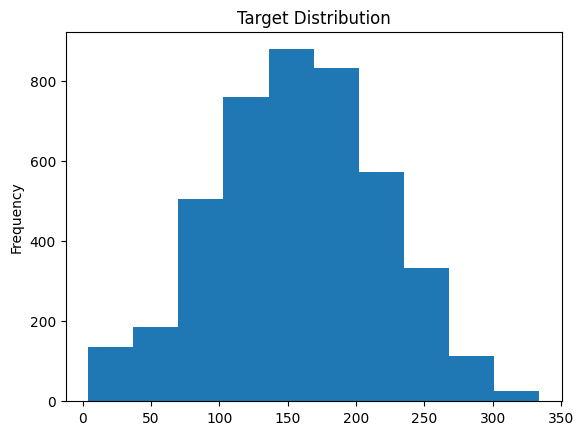

In [28]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [29]:
merged_df[["year", "composite_score", "uid"]]

,year,composite_score,uid
0,2021,175,aace
1,2021,206,aanz
2,2016,161,aape
3,2021,144,aape
4,2021,104,aard
...,...,...,...
4338,2021,152,zzag
4339,2016,140,zzci
4340,2021,121,zzci
4341,2021,32,zzjb


In [30]:
pivot_df = merged_df.pivot(index="uid", columns="year", values="composite_score")

In [31]:
# Pivot the DataFrame
pivot_df = merged_df.pivot(index="uid", columns="year", values="composite_score")

# Rename columns for clarity
pivot_df.columns = ['score_2016', 'score_2021']

# Drop rows with NaN values (uids without scores for both years)
pivot_df = pivot_df.dropna()

# Calculate the score difference
pivot_df["score_change"] = pivot_df["score_2016"] - pivot_df["score_2021"] 

merged_with_changes = merged_df.merge(
    pivot_df[['score_change']],  # Select only the score_change column
    on='uid',
    how='left'  # Ensure all rows from merged_df are retained
)

filtered_df = merged_with_changes[merged_with_changes['score_change'].notna()]

merged_changes_df = filtered_df.drop_duplicates(subset='uid', keep='first')

print(len(merged_df))
print(len(merged_changes_df))


# Pivot the DataFrame
pivot_df = merged_test.pivot(index="uid", columns="year", values="composite_score")

# Rename columns for clarity
pivot_df.columns = ['score_2016', 'score_2021']

# Drop rows with NaN values (uids without scores for both years)
pivot_df = pivot_df.dropna()

# Calculate the score difference
pivot_df["score_change"] = pivot_df["score_2016"] - pivot_df["score_2021"] 

merged_with_changes = merged_test.merge(
    pivot_df[['score_change']],  # Select only the score_change column
    on='uid',
    how='left'  # Ensure all rows from merged_df are retained
)

filtered_df = merged_with_changes[merged_with_changes['score_change'].notna()]


merged_test_changes_df = filtered_df.drop_duplicates(subset='uid', keep='first')

print(len(merged_test))
print(len(merged_test_changes_df))

KeyboardInterrupt: 

In [173]:
merged_changes_df

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12,year,composite_score,score_change
2,aape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2016,161,17.0
13,adtd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2016,272,18.0
15,aehw,3. 70–79,"0. <100,000",1. Married or in civil union,1.0,0. No education,4. 7+,0.0,3. Good,0.0,...,0.No,NaN,NaN,NaN,NaN,No 2,Concrete 2,2016,87,-5.0
20,afls,1. 50–59,"0. <100,000",1. Married or in civil union,1.0,0. No education,4. 7+,0.0,NaN,NaN,...,0.No,NaN,NaN,NaN,NaN,No 2,Concrete 2,2016,17,-31.0
33,aiac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2,2016,178,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,zyed,1. 50–59,"1. 100,000+",3. Widowed,1.0,2. 6 years,1. 1 or 2,0.0,5. Poor,0.0,...,0.No,NaN,NaN,NaN,NaN,No 2,Concrete 2,2016,156,28.0
4331,zyni,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2,2016,246,-6.0
4333,zytb,1. 50–59,"1. 100,000+",1. Married or in civil union,1.0,2. 6 years,2. 3 or 4,0.0,3. Good,0.0,...,1.Yes,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2016,262,1.0
4337,zzag,1. 50–59,"0. <100,000",1. Married or in civil union,1.0,1. 1–5 years,4. 7+,0.0,5. Poor,0.0,...,1.Yes,NaN,NaN,NaN,NaN,No 2,Concrete 2,2016,155,3.0


In [221]:
y=merged_changes_df['score_change']
data=pd.concat((merged_changes_df,merged_test_changes_df)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score', 'score_change', 'year'],axis=1)

In [179]:
# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [180]:
#separate train and test
merged_changes_df=data[:len(merged_changes_df)]
merged_test_changes_df=data[len(merged_changes_df):]

In [181]:
train_X, val_X, train_y, val_y = train_test_split(merged_changes_df, y,test_size=0.33,random_state=42)

In [182]:
val_y

3036    117.0
2738    -18.0
723       5.0
386     -50.0
1685     57.0
        ...  
54      -54.0
1655     13.0
818      13.0
3377     23.0
368     -13.0
Name: score_change, Length: 353, dtype: float64

In [183]:
'uid' in train_X.columns.tolist()

False

In [184]:
#The model shall handle missing values and encode categorical columns
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    loss_function='RMSE',  # Default regression loss
    cat_features=merged_changes_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)

In [185]:
model.fit(train_X, train_y,  eval_set=(val_X, val_y))

0:	learn: 30.9750911	test: 31.5667625	best: 31.5667625 (0)	total: 26.6ms	remaining: 26.6s
100:	learn: 15.8652482	test: 30.1570949	best: 30.0864745 (87)	total: 2.37s	remaining: 21.1s
200:	learn: 7.9102896	test: 30.2676238	best: 30.0864745 (87)	total: 5.21s	remaining: 20.7s
300:	learn: 3.6871153	test: 30.2908320	best: 30.0864745 (87)	total: 8.16s	remaining: 19s
400:	learn: 1.8766525	test: 30.3008589	best: 30.0864745 (87)	total: 11.2s	remaining: 16.7s
500:	learn: 0.9688375	test: 30.2808944	best: 30.0864745 (87)	total: 14.2s	remaining: 14.1s
600:	learn: 0.6087885	test: 30.2853539	best: 30.0864745 (87)	total: 17.3s	remaining: 11.5s
700:	learn: 0.3404834	test: 30.2869368	best: 30.0864745 (87)	total: 20.3s	remaining: 8.65s
800:	learn: 0.2130311	test: 30.2860980	best: 30.0864745 (87)	total: 23.5s	remaining: 5.83s
900:	learn: 0.1230282	test: 30.2869771	best: 30.0864745 (87)	total: 26.4s	remaining: 2.91s
999:	learn: 0.0690677	test: 30.2876762	best: 30.0864745 (87)	total: 29.4s	remaining: 0us

be

In [170]:
pred=model.predict(val_X)

In [142]:
pred

array([15.78299042, -5.1125361 , 25.95325193, ..., 17.22577076,
        5.0226815 ,  8.94395754])

In [171]:
val_y

3036    117.0
2738    -18.0
723       5.0
386     -50.0
1685     57.0
        ...  
54      -54.0
1655     13.0
818      13.0
3377     23.0
368     -13.0
Name: score_change, Length: 353, dtype: float64

Second model

In [12]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['composite_score'],axis=1)

In [13]:
# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [14]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [15]:
merged_df.shape

(4343, 185)

In [16]:
train_X, val_X, train_y, val_y = train_test_split(merged_df, y,test_size=0.33,random_state=42)

In [17]:
#The model shall handle missing values and encode categorical columns
model2 = CatBoostRegressor(
    iterations=7000,
    learning_rate=0.01,
    depth=10,
    loss_function='RMSE',  # Default regression loss
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)

In [18]:
model2.fit(train_X, train_y,  eval_set=(val_X, val_y))

0:	learn: 60.6179925	test: 60.7044705	best: 60.7044705 (0)	total: 94.3ms	remaining: 10m 59s
100:	learn: 45.4613451	test: 46.3435665	best: 46.3435665 (100)	total: 3.62s	remaining: 4m 6s
200:	learn: 39.3777565	test: 42.0563074	best: 42.0563074 (200)	total: 7.56s	remaining: 4m 15s
300:	learn: 35.8771940	test: 40.4125463	best: 40.4125463 (300)	total: 11.5s	remaining: 4m 14s
400:	learn: 33.7329592	test: 39.4172833	best: 39.4172833 (400)	total: 15s	remaining: 4m 6s
500:	learn: 32.0174250	test: 38.9785812	best: 38.9785812 (500)	total: 18.7s	remaining: 4m 2s
600:	learn: 30.6733821	test: 38.7283774	best: 38.7283774 (600)	total: 22.2s	remaining: 3m 56s
700:	learn: 29.4570925	test: 38.5524629	best: 38.5524629 (700)	total: 25.9s	remaining: 3m 53s
800:	learn: 28.4877482	test: 38.4047610	best: 38.4047610 (800)	total: 29.6s	remaining: 3m 48s
900:	learn: 27.5935926	test: 38.2885923	best: 38.2882181 (899)	total: 33.4s	remaining: 3m 46s
1000:	learn: 26.8099594	test: 38.2021138	best: 38.2021138 (1000)	to

In [206]:
pred=model2.predict(val_X)

In [207]:
val_X["predicted"]=pred
val_X["actual"]=val_y

In [208]:
val_X

,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,...,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12,year,predicted,actual
2566,Missing,Missing,Missing,NaN,Missing,Missing,NaN,Missing,NaN,NaN,...,0.No,NaN,NaN,Missing,Missing,Missing,"Wood, mosaic, or other covering 1",2016,220.224028,175
318,Missing,Missing,Missing,NaN,Missing,Missing,NaN,Missing,NaN,NaN,...,1.Yes,NaN,NaN,Missing,Missing,Missing,Concrete 2,2016,117.227961,88
1924,2. 60–69,"1. 100,000+",1. Married or in civil union,1.0,4. 10+ years,2. 3 or 4,0.0,3. Good,0.0,0.0,...,0.No,NaN,NaN,Missing,Missing,No 2,"Wood, mosaic, or other covering 1",2016,148.905013,172
157,1. 50–59,"1. 100,000+",3. Widowed,1.0,2. 6 years,2. 3 or 4,0.0,4. Fair,0.0,0.0,...,0.No,NaN,NaN,Missing,Missing,No 2,Concrete 2,2021,175.508941,218
315,3. 70–79,"0. <100,000",1. Married or in civil union,1.0,0. No education,4. 7+,0.0,4. Fair,0.0,0.0,...,1.Yes,NaN,NaN,Missing,Missing,No 2,"Wood, mosaic, or other covering 1",2021,84.259729,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Missing,Missing,Missing,NaN,Missing,Missing,NaN,Missing,NaN,NaN,...,1.Yes,NaN,NaN,Missing,Missing,Missing,"Wood, mosaic, or other covering 1",2016,140.707843,119
422,2. 60–69,"1. 100,000+",1. Married or in civil union,1.0,3. 7–9 years,2. 3 or 4,0.0,5. Poor,0.0,0.0,...,1.Yes,NaN,NaN,Missing,Missing,No 2,"Wood, mosaic, or other covering 1",2016,183.346619,232
1815,2. 60–69,"1. 100,000+",1. Married or in civil union,1.0,2. 6 years,2. 3 or 4,0.0,4. Fair,0.0,0.0,...,0.No,NaN,NaN,Missing,Missing,No 2,Concrete 2,2016,150.176648,159
3751,1. 50–59,"1. 100,000+",1. Married or in civil union,2.0,1. 1–5 years,2. 3 or 4,1.0,4. Fair,0.0,0.0,...,0.No,NaN,NaN,Missing,Missing,No 2,Concrete 2,2021,153.234302,225


In [35]:
score =root_mean_squared_error(val_y, pred)

In [36]:
score

37.57687290178368

In [37]:
#lets generate prediction
fin_pred = model.predict(merged_test)

In [38]:
ss.head()


,uid,year,composite_score
0,abxu,2016,0
1,aeol,2016,0
2,aeol,2021,0
3,afnb,2016,0
4,afnb,2021,0


In [ ]:
ss['composite_score']=fin_pred
#they want ints not floats, so change
ss['composite_score'] = ss['composite_score'].astype(int)
#generate submission
ss.to_csv('../dataset/cat_boost_baseline.csv', index=False)